<a href="https://colab.research.google.com/github/kotharisanjana/CMPE258_DeepLearning_Spring2023/blob/main/Assignment_3/e_NN_Tensorflow_variations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers.legacy import SGD

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Generate non-linear data

n = 500
dim = 3
x = tf.random.uniform([n, dim], dtype=tf.float32)
print('Input shape =', x.shape)

Input shape = (500, 3)


In [3]:
# Initialize weights and bias

weights = tf.transpose(tf.Variable([[2.0, -3.0, 1.0]], dtype=tf.float32))
bias = tf.Variable([8], dtype=tf.float32)
print('Weights shape =', weights.shape)
print('Bias shape =', bias.shape)

# non-linear 3 variable function we want to learn
y_true = tf.einsum('ij, jk -> ik', (x**3),  weights) + tf.einsum('ij, jk -> ik', (x**2),  weights) + tf.einsum('ij, jk -> ik', x, weights) + bias
print('Function output shape =', y_true.shape)

Weights shape = (3, 1)
Bias shape = (1,)
Function output shape = (500, 1)


In [4]:
# Hyperparamter initializations

input_dim = dim
output_dim = 1
hidden_dim = 16

learning_rate = 0.01
num_epochs = 50

#### Non-linear regression using tensorflow low level API

In [5]:
# Weights and biases for each of the layers
W1 = tf.Variable(tf.random.normal([input_dim, hidden_dim]))
b1 = tf.Variable(tf.zeros([hidden_dim]))
W2 = tf.Variable(tf.random.normal([hidden_dim, hidden_dim]))
b2 = tf.Variable(tf.zeros([hidden_dim]))
W3 = tf.Variable(tf.random.normal([hidden_dim, output_dim]))
b3 = tf.Variable(tf.zeros([output_dim]))

# Forward pass
def forward(X):
  h1 = tf.nn.relu(tf.matmul(tf.convert_to_tensor(x), W1) + b1)
  h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
  y_pred = tf.matmul(h2, W3) + b3
  return y_pred

# Loss function
def loss(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true - y_pred))

# define the optimizer
optimizer = tf.optimizers.SGD(learning_rate)

# define the training step
def train(x, y_true):
  with tf.GradientTape() as tape:
    y_pred = forward(x)
    loss_value = loss(y_true, y_pred)
  gradients = tape.gradient(loss_value, [W1, b1, W2, b2, W3, b3])
  optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2, W3, b3]))
  return loss_value

# train the model
loss_ = []
for epoch in range(num_epochs):
    loss_value = train(x, y_true)
    loss_.append(loss_value)
    print(f"Epoch {epoch}: Loss = {loss_value}")

Epoch 0: Loss = 123.55101013183594
Epoch 1: Loss = 43.04191589355469
Epoch 2: Loss = 49.20087432861328
Epoch 3: Loss = 12.013445854187012
Epoch 4: Loss = 10.203354835510254
Epoch 5: Loss = 8.775039672851562
Epoch 6: Loss = 7.470931053161621
Epoch 7: Loss = 6.360830783843994
Epoch 8: Loss = 5.383888244628906
Epoch 9: Loss = 4.629810810089111
Epoch 10: Loss = 4.052268028259277
Epoch 11: Loss = 3.6019484996795654
Epoch 12: Loss = 3.216137409210205
Epoch 13: Loss = 2.9236934185028076
Epoch 14: Loss = 2.6708121299743652
Epoch 15: Loss = 2.5097992420196533
Epoch 16: Loss = 2.3620731830596924
Epoch 17: Loss = 2.3441128730773926
Epoch 18: Loss = 2.2927074432373047
Epoch 19: Loss = 2.4580166339874268
Epoch 20: Loss = 2.5390124320983887
Epoch 21: Loss = 3.042307138442993
Epoch 22: Loss = 3.2212541103363037
Epoch 23: Loss = 4.304662704467773
Epoch 24: Loss = 4.238424301147461
Epoch 25: Loss = 5.9095306396484375
Epoch 26: Loss = 4.916622161865234
Epoch 27: Loss = 6.579998970031738
Epoch 28: Loss =

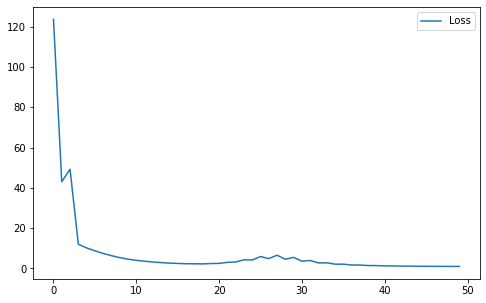

In [6]:
# Plot epoch vs loss

plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_, label='Loss')
plt.legend()

From the plot above, we see that the loss reduces as the number of epochs increases. This is because the model is learning the underlying function. Backpropagation updates weights and biases so as to minimize the loss which is seen from the 50 epochs above.

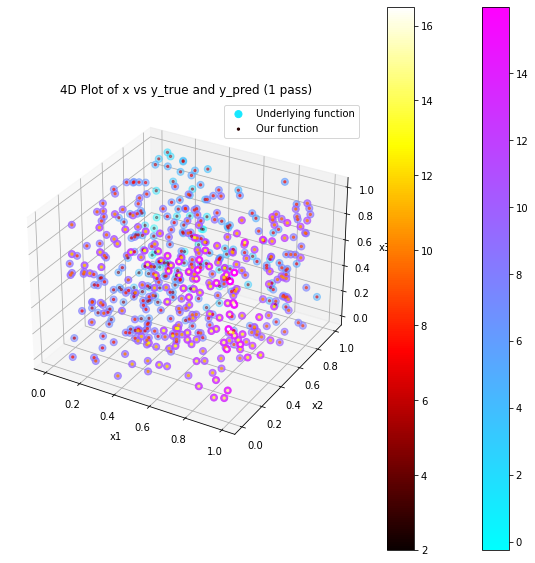

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_true, cmap='cool', label='Underlying function', s=50)
fig.colorbar(sc)
sc = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=forward(x), cmap='hot', label='Our function', marker='.')
fig.colorbar(sc)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('4D Plot of x vs y_true and y_pred (1 pass)')

plt.legend()
plt.show()

If zoomed into the above plot, we see that the learned function ('.') is amost overlaping with the true underlying function ('●'). By looking at the colorbar, we can confirm that the network has done a decent job in learning the underlying function.

#### Using builtin layers

In [8]:
# Define linear layer class

class Linear(Layer):
  def __init__(self, units):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.wts = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
      self.bias = self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)

  def call(self, inputs):
      return tf.einsum('ij, jk -> ik', inputs, self.wts) + self.bias

In [9]:
# Non-linear regression model

class Model(Layer):
  def __init__(self):
      super(Model, self).__init__()
      self.input_layer = Linear(input_dim)
      self.hidden_1 = Linear(hidden_dim)
      self.hidden_2 = Linear(hidden_dim)
      self.output_layer = Linear(output_dim)

  def call(self, input, training=None):
      x = self.input_layer(input)
      x = tf.nn.relu(x)
      x = self.hidden_1(x)
      x = tf.nn.relu(x)
      x = self.hidden_2(x)
      x = tf.nn.relu(x)
      x = self.output_layer(x)
      return x

In [10]:
# Initialize model and train
model = Model()
y_pred = model(x, training=True)

#### Using tensorflow functional API

In [11]:
# Non-linear regression model (Functional API)

x_ = tf.keras.layers.Input(shape=(input_dim,))
h1 = tf.keras.layers.Dense(hidden_dim, activation='relu')(x_)
h2 = tf.keras.layers.Dense(hidden_dim, activation='relu')(h1)
y = tf.keras.layers.Dense(output_dim, activation=None)(h2)

In [12]:
# Define optimizer and loss function

optimizer = SGD(lr=learning_rate)
loss = tf.keras.losses.MeanSquaredError()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model = tf.keras.Model(inputs=x_, outputs=y)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# Compile and fit model

model.compile(optimizer=optimizer, loss=loss)
model.fit(x, y_true, epochs=num_epochs)
y_pred = model.predict(x)

Epoch 1/50
16/16 [==============================] - 1s 9ms/step - loss: 34.1486
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 4.3392
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 1.7031
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.7243
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.6047
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.5046
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.5072
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.4655
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.4760
Epoch 10/50
16/16 [==============================] - 0s 5ms/step - loss: 0.4514
Epoch 11/50
16/16 [==============================] - 0s 9ms/step - loss: 0.4581
Epoch 12/50
16/16 [==============================] - 0s 4ms/step - loss: 0.4207
Epoch 13/50
16/16 [============================

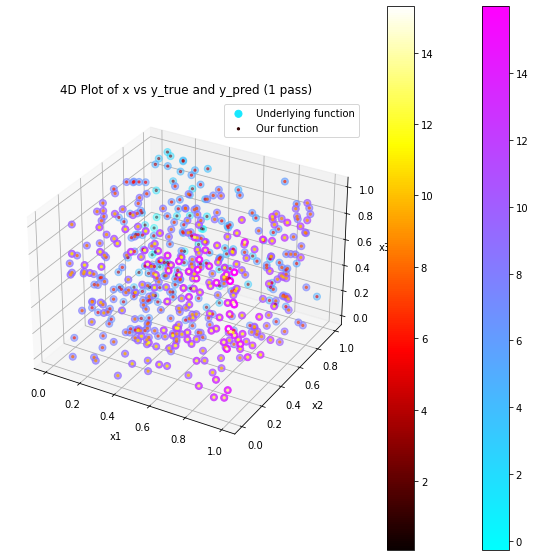

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_true, cmap='cool', label='Underlying function', s=50)
fig.colorbar(sc)
sc = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_pred, cmap='hot', label='Our function', marker='.')
fig.colorbar(sc)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('4D Plot of x vs y_true and y_pred (1 pass)')

plt.legend()
plt.show()

After 50 epochs, the model has learnt the underlying function as is evident from the loss reducing and the color of the points matching (as per the colorbar) in the plot above.

#### Using tensoflow high level API - Keras

In [16]:
# Non-linear regression model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_dim, input_dim=input_dim, activation=tf.nn.relu),
    tf.keras.layers.Dense(hidden_dim, activation=tf.nn.relu),
    tf.keras.layers.Dense(output_dim, activation=None)
])

In [17]:
# Define optimizer and loss function

optimizer = SGD(lr=learning_rate)
loss = tf.keras.losses.MeanSquaredError()

In [18]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss)

# Model training
history = model.fit(x, y_true, epochs=num_epochs)

Epoch 1/50
16/16 [==============================] - 1s 8ms/step - loss: 39.6618
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 6.6969
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 2.9179
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 1.1105
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.6776
Epoch 6/50
16/16 [==============================] - 0s 9ms/step - loss: 0.5623
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 0.5728
Epoch 8/50
16/16 [==============================] - 0s 7ms/step - loss: 0.5144
Epoch 9/50
16/16 [==============================] - 0s 8ms/step - loss: 0.5591
Epoch 10/50
16/16 [==============================] - 0s 6ms/step - loss: 0.4746
Epoch 11/50
16/16 [==============================] - 0s 8ms/step - loss: 0.4838
Epoch 12/50
16/16 [==============================] - 0s 10ms/step - loss: 0.4477
Epoch 13/50
16/16 [============================

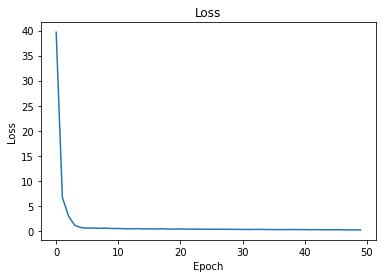

In [19]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()